In [26]:
library(tidyverse)
library(cowplot)
library(ggpubr)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




# Determine how columns are computed

In [35]:
gwas_df <- read_tsv("data/gwas/saige/features/feature_01.txt", show_col_types = F) |>
    rename(var_T = var)

gwas_df |> head(2)

CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var_T,p.value,N
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,SNP_1,0,0,1193,0.5965,0,-0.0678746,0.0374286,-48.4507,713.827,0.06976366,1000
1,0,SNP_10,0,0,1226,0.6130,0,-0.0267078,0.0375506,-18.9410,709.196,0.47693090,1000


In [36]:
back_df <- gwas_df |>
    mutate(
        beta_hat = Tstat / var_T,
        se_hat = abs(1 / sqrt(var_T)),
    ) |>
    select(MarkerID, BETA, SE, beta_hat, se_hat)

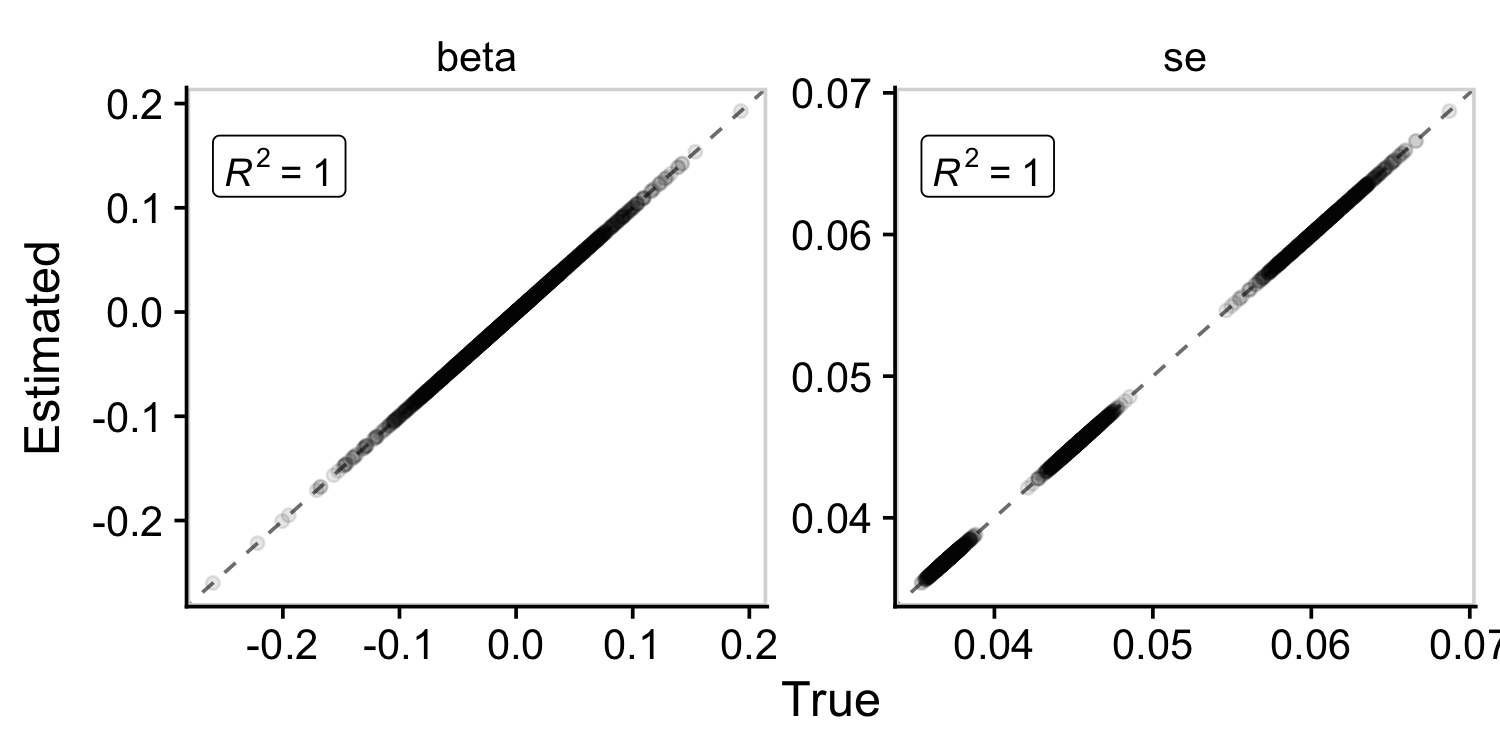

In [37]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 250)

back_df |>
    pack(beta = c(BETA, beta_hat), se = c(SE, se_hat)) |>
    mutate(across(c(beta, se), ~set_names(., c("true", "est")))) |>
    pivot_longer(c(beta, se)) |>
    unpack(value) |>
    ggplot(aes(x = true, y = est)) +
    geom_abline(slope = 1, intercept = 0, color = "gray50", linetype = "dashed") +
    geom_point(alpha = 0.1) +
    facet_wrap(vars(name), nrow = 1, scales = "free") +
    theme_cowplot() +
    theme(
        strip.background = element_rect(fill = "white")
    ) +
    panel_border() +
    xlab("True") +
    ylab("Estimated") +
    stat_cor(aes(label = after_stat(rr.label)), geom = "label")

# Determine indirect $T$ and $\mathrm{Var}(T)$

In [63]:
projection_gwas_df <- read_tsv("data/gwas/saige/projections/projection_001.txt", show_col_types = F) |>
    filter(MarkerID == "SNP_1")

projection_gwas_df

CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,N
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,SNP_1,0,0,1193,0.5965,0,-0.0330835,0.0448771,-16.4272,496.536,0.4609987,1000


In [61]:
feature_gwas_df <- fs::dir_ls("data/gwas/saige/features/", glob = "*feature_*.txt") |>
    discard(~str_detect(., "variance")) |>
    read_tsv(id = "feature", show_col_types = F) |>
    rename(var_T = var) |>
    filter(MarkerID == "SNP_1") |>
    mutate(
        feature = feature |>
            str_remove("^data/gwas/saige/features/") |>
            str_remove(".txt$")
    )

feature_gwas_df |> head(2)

feature,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var_T,p.value,N
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
feature_01,1,0,SNP_1,0,0,1193,0.5965,0,-0.0678746,0.0374286,-48.4507,713.827,0.06976366,1000
feature_02,1,0,SNP_1,0,0,1193,0.5965,0,-0.0969872,0.0432314,-51.8940,535.060,0.02486805,1000


In [74]:
projection_matrix <- read_tsv("data/projected-phenotypes//projection_matrix.tsv", show_col_types = F) |>
    select(index, projection_001) |>
    column_to_rownames("index") |>
    as.matrix()

In [77]:
T_mat <- feature_gwas_df |>
    select(feature, Tstat) |>
    column_to_rownames("feature") |>
    as.matrix()

var_T_mat <- feature_gwas_df |>
    select(feature, var_T) |>
    column_to_rownames("feature") |>
    as.matrix()

In [80]:
t(T_mat) %*% projection_matrix

,projection_001
Tstat,-15.03873


In [84]:
t(var_T_mat) %*% projection_matrix

,projection_001
var_T,-165.314


## Figure out the missing factor

If we take a single SNP from each projection and compute the factor by which the indirect standard error is off, this makes the standard errors fit essentially perfectly. This would make SAIGE as good an indirect method as FastGWA, at least.

So we need to figure out where a factor is missing.

In [131]:
features_df <- read_tsv("data/simulated-phenotypes/Ysim_saige.txt", show_col_types = F)
features_df |> head(2)

FID,IID,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,sharedConfounder_norm1,sharedConfounder_norm2,sharedConfounder_norm3,independentConfounder_norm1,independentConfounder_norm2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ID_1,ID_1,-1.946783,-1.207065,-1.5889695,-1.9544865,-1.5568856,-1.080898,-2.3245073,-0.5967468,-1.921959,-0.7205518,1.079511,0.6758174,0.335099,1.812403,-0.38338539
ID_2,ID_2,-2.037948,0.431467,-0.1582564,-0.8199567,0.3348804,-2.315758,-0.5927869,-2.0397109,-1.639610,-0.3405350,2.308693,-0.2111481,-1.933398,1.139712,0.08748401


In [132]:
load_rda <- function(file) {
    env <- rlang::env()
    load(file, envir = env)
    env$modglmm
}

residuals_df <- fs::dir_ls("data/gwas/saige/features/", glob = "*feature_*.rda") |>
    map(load_rda) |>
    map(~.$residuals) |>
    map(as.double) |>
    bind_cols() |>
    rename_with(\(x) x |> str_remove("data/gwas/saige/features/") |> str_remove(".rda"))

residual_cov_df <- residuals_df |> cov()

In [133]:
e1 |> names()

[1] "theta"                 "coefficients"          "linear.predictors"    
 [4] "fitted.values"         "Y"                     "residuals"            
 [7] "cov"                   "converged"             "sampleID"             
[10] "obj.noK"               "y"                     "X"                    
[13] "traitType"             "isCovariateOffset"     "LOCO"                 
[16] "obj.glm.null"          "offset"                "useSparseGRMtoFitNULL"

In [173]:
((e1$y - e1$fitted.values) == e1$residuals) |> all()

[1] TRUE

In [138]:
g <- read_tsv("data/simulated-phenotypes/Genotypes.raw", show_col_types = FALSE) |>
    select(IID, g = `SNP_1_.`)
g |> head(2)

IID,g
<chr>,<dbl>
ID_1,1
ID_2,1


In [143]:
pheno_df <- read_tsv("data/simulated-phenotypes/Ysim_saige.txt", show_col_types = F) |>
    select(-FID) |>
    inner_join(g, by = "IID")

pheno_df |> head(2)

IID,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,sharedConfounder_norm1,sharedConfounder_norm2,sharedConfounder_norm3,independentConfounder_norm1,independentConfounder_norm2,g
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ID_1,-1.946783,-1.207065,-1.5889695,-1.9544865,-1.5568856,-1.080898,-2.3245073,-0.5967468,-1.921959,-0.7205518,1.079511,0.6758174,0.335099,1.812403,-0.38338539,1
ID_2,-2.037948,0.431467,-0.1582564,-0.8199567,0.3348804,-2.315758,-0.5927869,-2.0397109,-1.639610,-0.3405350,2.308693,-0.2111481,-1.933398,1.139712,0.08748401,1


In [125]:
beta_vec <- feature_gwas_df |>
    select(feature, BETA) |>
    pull(BETA, name = "feature")

se_vec <- feature_gwas_df |>
    select(feature, SE) |>
    pull(SE, name = "feature")

In [150]:
X_covar <- pheno_df |>
    select(contains("Confounder")) |>
    mutate(const = 1.0) |>
    as.matrix()

P <- diag(nrow = 1000) - X_covar %*% solve(t(X_covar) %*% X_covar) %*% t(X_covar)

In [160]:
X_features <- pheno_df |>
    select(starts_with("feature_")) |>
    as.matrix()

raw_cov <- X_features |> cov()
resid_cov <- (P %*% X_features) |> cov()
saige_resid_cov <- residuals_df |> cov()
double_residual_cov <- (P %*% as.matrix(residuals_df)) |> cov()

In [167]:
diag(cov(X_features)) / ((1000 - 6) * se_vec^2 + beta_vec^2)
diag(cov(P %*% X_features)) / ((1000 - 6) * se_vec^2 + beta_vec^2)
diag(cov(residuals_df)) / ((1000 - 6) * se_vec^2 + beta_vec^2)
diag(cov(P %*% as.matrix(residuals_df))) / ((1000 - 6) * se_vec^2 + beta_vec^2)

feature_01 feature_02 feature_03 feature_04 feature_05 feature_06 feature_07 
 0.7157675  0.5355765  0.5156678  0.6342708  0.5301282  0.9896865  0.5754848 
feature_08 feature_09 feature_10 
 0.7024065  0.5271510  0.5153692

feature_01 feature_02 feature_03 feature_04 feature_05 feature_06 feature_07 
 0.5938617  0.5221048  0.4997463  0.5577682  0.4787159  0.4993675  0.5718696 
feature_08 feature_09 feature_10 
 0.5613128  0.5011220  0.4962287

feature_01 feature_02 feature_03 feature_04 feature_05 feature_06 feature_07 
 0.1408404  0.2084440  0.2607626  0.1681498  0.3272822  0.2623222  0.1585433 
feature_08 feature_09 feature_10 
 0.1660131  0.2506899  0.2730317

feature_01 feature_02 feature_03 feature_04 feature_05 feature_06 feature_07 
 0.1404487  0.2081632  0.2606784  0.1679264  0.3272259  0.2622866  0.1583553 
feature_08 feature_09 feature_10 
 0.1659001  0.2505720  0.2730016

In [168]:
var(P %*% pheno_df$g)

0.4676509


In [174]:
residual_cov_df

,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10
feature_01,0.19676835,0.14232285,0.05524608,0.16234289,0.19455450,-0.059748640,0.12325941,0.126023524,0.17427630,0.05274641
feature_02,0.14232285,0.38919561,0.28202960,0.11123135,0.30209436,-0.064339350,0.10990062,0.016914975,0.21660167,0.01012322
feature_03,0.05524608,0.28202960,0.50567940,0.04066833,0.35302901,-0.077383404,0.02098735,-0.125954979,0.20561110,-0.10889156
feature_04,0.16234289,0.11123135,0.04066833,0.26510729,0.17742810,0.013961832,0.13248785,0.140829971,0.15632219,0.09794610
feature_05,0.19455450,0.30209436,0.35302901,0.17742810,0.61736438,-0.189125083,0.06703706,0.045520858,0.38397167,-0.13413486
feature_06,-0.05974864,-0.06433935,-0.07738340,0.01396183,-0.18912508,0.265055906,0.06395614,0.002572134,-0.14149766,0.19991586
feature_07,0.12325941,0.10990062,0.02098735,0.13248785,0.06703706,0.063956142,0.27549521,0.132295918,0.06078351,0.23934281
feature_08,0.12602352,0.01691497,-0.12595498,0.14082997,0.04552086,0.002572134,0.13229592,0.236349107,0.09002161,0.12119239
feature_09,0.17427630,0.21660167,0.20561110,0.15632219,0.38397167,-0.141497663,0.06078351,0.090021606,0.47555613,-0.08719396
feature_10,0.05274641,0.01012322,-0.10889156,0.09794610,-0.13413486,0.199915860,0.23934281,0.121192391,-0.08719396,0.52977883


In [ ]:
residual_cov_df

In [175]:
diag(residual_cov_df)

feature_01 feature_02 feature_03 feature_04 feature_05 feature_06 feature_07 
 0.1967683  0.3891956  0.5056794  0.2651073  0.6173644  0.2650559  0.2754952 
feature_08 feature_09 feature_10 
 0.2363491  0.4755561  0.5297788

In [227]:
feature_gwas_df <- fs::dir_ls("data/gwas/saige/features/", glob = "*feature_*.txt") |>
    discard(~str_detect(., "variance")) |>
    read_tsv(id = "feature", show_col_types = F) |>
    rename(var_T = var) |>
    mutate(
        feature = feature |>
            str_remove("^data/gwas/saige/features/") |>
            str_remove(".txt$")
    )

feature_gwas_df |> head(2)

feature,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var_T,p.value,N
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
feature_01,1,0,SNP_1,0,0,12072,0.6036,0,-0.00427858,0.0130565,-25.0985,5866.08,0.7431404000,10000
feature_01,1,0,SNP_10,0,0,11980,0.5990,0,-0.04368020,0.0130086,-258.1220,5909.35,0.0007856496,10000


In [228]:
df1 <- feature_gwas_df |>
    filter(feature == "feature_01") |>
    column_to_rownames("MarkerID") |>
    select(BETA, SE, N)

In [229]:
df2 <- feature_gwas_df |>
    filter(feature == "feature_02") |>
    column_to_rownames("MarkerID") |>
    select(BETA, SE, N)

In [230]:
p <- c(1, 1)
n_covar <- 14

var_g_1 <- cov_df[1, 1] / ((df1$N - n_covar) * df1$SE^2 + df1$BETA^2)
var_g_2 <- cov_df[2, 2] / ((df2$N - n_covar) * df2$SE^2 + df2$BETA^2)
var_g_hat <- map2_dbl(var_g_1, var_g_2, mean)

In [231]:
var_p_1 <- load_rda("data/gwas/saige/features/feature_01.rda")$residuals |> var() |> as.double()
var_p_2 <- load_rda("data/gwas/saige/features/feature_02.rda")$residuals |> var() |> as.double()

var_g_1 <- var_p_1 / ((df1$N - 6) * df1$SE^2 + df1$BETA^2)
var_g_2 <- var_p_2 / ((df2$N - 6) * df2$SE^2 + df2$BETA^2)

var_g_1 |> head()
var_g_2 |> head()

[1] 0.4019971 0.4045110 0.4102184 0.2722056 0.2758833 0.2751203

[1] 0.3909318 0.3937594 0.3989817 0.2647296 0.2683151 0.2677547

# Simple

In [220]:
resid_df <- data.frame(
    feature_01 = load_rda("debug/feature_01.rda")$residuals,
    feature_02 = load_rda("debug/feature_02.rda")$residuals
)

cov_df <- resid_df %>% cov

df1 <- read_tsv("debug/feature_01.txt", show_col_types = F, col_types = cols(MarkerID = col_character()))
df2 <- read_tsv("debug/feature_02.txt", show_col_types = F, col_types = cols(MarkerID = col_character()))

cov_df

,feature_01,feature_02
feature_01,0.1967684,0.1423229
feature_02,0.1423229,0.3891955


In [221]:
n_covar <- 5

var_g_1 <- cov_df[1, 1] / ((df1$N - n_covar) * df1$SE^2 + df1$BETA^2)
var_g_2 <- cov_df[2, 2] / ((df2$N - n_covar) * df2$SE^2 + df2$BETA^2)
var_g_hat <- map2_dbl(var_g_1, var_g_2, mean)

var_g_1 |> head(2)
var_g_2 |> head(2)

[1] 0.1406994 0.1401773

[1] 0.2082355 0.2077109

In [225]:
df1 |> head()

CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,N
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,SNP_1,0,0,807,0.4035,0,0.0678746,0.0374286,48.45070,713.827,0.06976359,1000
1,0,SNP_10,0,0,774,0.3870,0,0.0267078,0.0375506,18.94100,709.196,0.47693100,1000
1,0,SNP_100,0,0,830,0.4150,0,-0.0128749,0.0358260,-10.03110,779.119,0.71931600,1000
1,0,SNP_1000,0,0,385,0.1925,0,0.0119601,0.0456278,5.74481,480.331,0.79322670,1000
1,0,SNP_1001,0,0,419,0.2095,0,0.0332746,0.0435194,17.56900,528.000,0.44451510,1000
1,0,SNP_1002,0,0,386,0.1930,0,0.0215224,0.0454023,10.44080,485.114,0.63547340,1000


In [224]:
df2 |> head()

CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,N
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,SNP_1,0,0,807,0.4035,0,0.0969872,0.0432314,51.89400,535.060,0.02486806,1000
1,0,SNP_10,0,0,774,0.3870,0,0.0445599,0.0433723,23.68750,531.588,0.30424100,1000
1,0,SNP_100,0,0,830,0.4150,0,0.0376361,0.0413803,21.97950,584.000,0.36307640,1000
1,0,SNP_1000,0,0,385,0.1925,0,0.0032754,0.0527017,1.17927,360.039,0.95044360,1000
1,0,SNP_1001,0,0,419,0.2095,0,0.0310826,0.0502665,12.30160,395.771,0.53634040,1000
1,0,SNP_1002,0,0,386,0.1930,0,0.0382519,0.0524413,13.90930,363.625,0.46574290,1000
